In [5]:
# all imports
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import StandardScaler
import os
import time

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor,Resize,ColorJitter,CenterCrop,Grayscale
import torchvision.models as models

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

In [6]:
# defining functions

# reads xml-data
def read_data(file):
    with open(file, 'r') as f:
        data = f.read()
    bs_data = bs(data, 'xml') 
    return bs_data


# gets the bname for calculations
def get_bname(path):
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            bs_data = read_data(path + xml_file)
            b_name = bs_data.find_all('name')
            return b_name    


# returns a dataframe given some data
def values_df(bs_data, low, high):
    b_name = bs_data.find_all('name')
    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    
    # finds x-, y- and z-values and computes euclidian distance
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df


# calculates the euclidian values
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    return r


# calculates difference between max and min 
def get_differences_values(path, low, high):
    i = 0
    diff_list = []
    
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            try:
                bs_data = read_data(path + xml_file)
                b_name = bs_data.find_all('name')
                
                # fix since these values for some reason don't work when passed as arguments
                if low >= 3*int(len(b_name)/4):
                    low = 3*int(len(b_name)/4)
                    high = int(len(b_name))
                    
                df1 = values_df(bs_data, low, high)

                df_max = pd.DataFrame(df1.max().to_dict(),index=[df1.index.values[-1]])
                df_min = pd.DataFrame(df1.min().to_dict(),index=[df1.index.values[-1]])
                df1 = df_max.subtract(df_min, fill_value=0)
                df1 = df1.rename(index={100:i})

                diff_list.append(df1)
                i+=1
            except:
                 print(xml_file + " failed to compute")
        else:
            continue
            
    if "healthy" in path.lower():
        injurylevel = [0 for i in range(len(diff_list))]
    else: 
        injurylevel = [1 for i in range(len(diff_list))]
    data_level1 = pd.concat(diff_list)
    data_level1['Injury level'] = injurylevel
    print(f"Length of how many timeseries-files of {path} people we have between files {low} and {high}: {i}")

    return data_level1


# gets accuracy of the algorithms

def get_accuracy(algorithm, data, test_size):
    if algorithm == KNeighborsClassifier:
        classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    elif algorithm == RandomForestClassifier:
        classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    else:
        classifier = algorithm()
    y = data['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = data.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# creating custom datasets

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
def get_attributes():
    # get the attributes
    path = "USE THIS/PFPS/"
    xml_file = 'timeseries-11.xml'
    bs_data = read_data(path+xml_file)
    b_name = bs_data.find_all('name')

    attributes = []
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(set(attributes))
    return attributes
    

# returns probability of a person having PFPS
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    if y_pred_tag == y_test:
        return True
    else:
        return False

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.fc2 = nn.Linear(in_features = 16, out_features = 8)
        self.out = nn.Linear(in_features = 8, out_features = 1)
        
    def forward(self, t):
        t = t
        
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        
        return t


## Preprocessing the data

Calculating the differences between the max and min-values in each attribute for each person in the four power levels.

In [7]:
# calculate the four power levels for healthy people:

path = "usethis/Healthy/"

b_name = get_bname(path)

diff_list1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list4 = get_differences_values(path, int(3*len(b_name)/4), int(len(b_name)))


# calculate the four power levels for injured people:

path = "usethis/PFPS/"

diff_list_injured1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list_injured2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list_injured3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list_injured4 = get_differences_values(path, int(3*len(b_name)/4), len(b_name))


# combine the data into the same dataframes

df_healthy = pd.concat([diff_list1, diff_list2, diff_list3, diff_list4])
df_pfps = pd.concat([diff_list_injured1, diff_list_injured2, diff_list_injured3, diff_list_injured4])
df_combined = pd.concat([df_healthy, df_pfps])

data3_level1 = pd.concat([diff_list1, diff_list_injured1]).reset_index(drop = True)
data3_level2 = pd.concat([diff_list2, diff_list_injured2]).reset_index(drop = True)
data3_level3 = pd.concat([diff_list3, diff_list_injured3]).reset_index(drop = True)
data3_level4 = pd.concat([diff_list4, diff_list_injured4]).reset_index(drop = True)


Length of how many timeseries-files of usethis/Healthy/ people we have between files 0 and 32: 20
Length of how many timeseries-files of usethis/Healthy/ people we have between files 32 and 64: 20
Length of how many timeseries-files of usethis/Healthy/ people we have between files 64 and 96: 20
Length of how many timeseries-files of usethis/Healthy/ people we have between files 93 and 126: 20
Length of how many timeseries-files of usethis/PFPS/ people we have between files 0 and 32: 20
Length of how many timeseries-files of usethis/PFPS/ people we have between files 32 and 64: 20
Length of how many timeseries-files of usethis/PFPS/ people we have between files 64 and 96: 20
Length of how many timeseries-files of usethis/PFPS/ people we have between files 93 and 125: 20


## Preprocessing the data

Dividing the data into training and test data. 

In [8]:
def get_ml_data(df_healthy, df_pfps):
    df_combined = pd.concat([df_healthy, df_pfps])

    y = df_combined['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = df_combined.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    return X, X_test, X_train, y_test, y_train

In [12]:
X, X_test, X_train, y_test, y_train = get_ml_data(df_healthy, df_pfps)

X1, X_test1, X_train1, y_test1, y_train1 = get_ml_data(diff_list1, diff_list_injured1)
X2, X_test2, X_train2, y_test2, y_train2 = get_ml_data(diff_list2, diff_list_injured2)
X3, X_test3, X_train3, y_test3, y_train3 = get_ml_data(diff_list3, diff_list_injured3)
X4, X_test4, X_train4, y_test4, y_train4 = get_ml_data(diff_list4, diff_list_injured4)

def get_X_data(X_test, X_train):
    

    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    return X_train, X_test

X_train, X_test = get_X_data(X_test, X_train)

X_train1, X_test1 = get_X_data(X_test1, X_train1)
X_train2, X_test2 = get_X_data(X_test2, X_train2)
X_train3, X_test3 = get_X_data(X_test3, X_train3)
X_train4, X_test4 = get_X_data(X_test4, X_train4)

data_list = [(X_test1, X_train1, y_train1, y_test1, 1), 
             (X_test2, X_train2, y_train2, y_test2, 2), 
             (X_test3, X_train3, y_train3, y_test3, 3), 
             (X_test4, X_train4, y_train4, y_test4, 4),
             (X_test, X_train, y_train, y_test, "ALL")]

    Injury level
3              0
12             1
16             1
6              1
16             0
17             1
9              1
3              1
13             1
19             1
3              0
4              0
8              1
15             0
17             1
4              0
19             0
4              1
16             1
10             0
19             0
12             0
9              1
10             1
5              0
12             1
15             1
19             0
7              1
1              1
19             0
3              0
[[-0.50891077  0.77708066 -0.09253942 ...  0.91371615 -0.21560374
  -0.7011647 ]
 [-0.53852933 -0.43738542 -0.2300311  ...  0.48585419 -0.63212193
  -0.37133991]
 [ 0.10227792  0.58708037 -0.40657021 ... -0.73052623 -0.88836155
  -0.26019857]
 ...
 [-0.81696929 -0.57418283  0.13763307 ... -0.11611991 -0.75960077
  -0.46703736]
 [-0.48189132 -0.07564178 -0.18104416 ... -2.26218963 -0.1474643
   0.2177767 ]
 [ 0.58358095  1.34847611 -0.0

## Logistic regression

Calculates the confusion matrix, accuracy score and cross-validation scores using scikit-learn.

For further documentation please see [scikit-learn documentation](https://scikit-learn.org/stable/)

Logistic Regression at level 1
The accuracy score is: 0.25
The confusion matrix at level 1 is: 
 [[1 3]
 [3 1]]
The cv scores at level 1 are [0.5        0.75       0.66666667 0.66666667 0.66666667 1.
 0.66666667 0.         0.66666667 0.66666667]
The mean accuracy of cv: 0.625


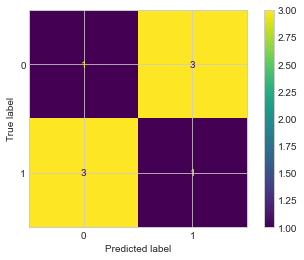

Logistic Regression at level 2
The accuracy score is: 0.625
The confusion matrix at level 2 is: 
 [[1 2]
 [1 4]]
The cv scores at level 2 are [0.75       0.75       1.         0.66666667 1.         1.
 1.         0.66666667 0.66666667 0.        ]
The mean accuracy of cv: 0.75


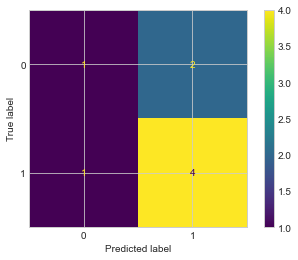

Logistic Regression at level 3
The accuracy score is: 0.625
The confusion matrix at level 3 is: 
 [[1 1]
 [2 4]]
The cv scores at level 3 are [0.75       0.5        0.33333333 0.66666667 1.         1.
 0.66666667 0.33333333 0.33333333 0.33333333]
The mean accuracy of cv: 0.5916666666666666


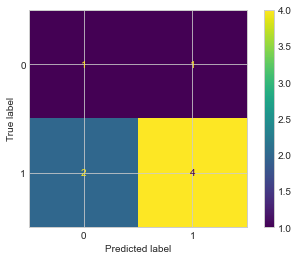

Logistic Regression at level 4
The accuracy score is: 0.75
The confusion matrix at level 4 is: 
 [[4 1]
 [1 2]]
The cv scores at level 4 are [0.5        0.75       0.66666667 0.33333333 0.33333333 1.
 0.33333333 0.         0.33333333 0.        ]
The mean accuracy of cv: 0.425


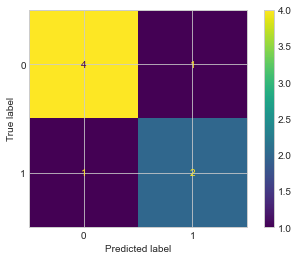

Logistic Regression at level ALL
The accuracy score is: 0.78125
The confusion matrix at level ALL is: 
 [[18  4]
 [ 3  7]]
The cv scores at level ALL are [0.76923077 0.84615385 1.         0.92307692 0.84615385 0.84615385
 0.92307692 0.76923077 0.66666667 1.        ]
The mean accuracy of cv: 0.8589743589743591


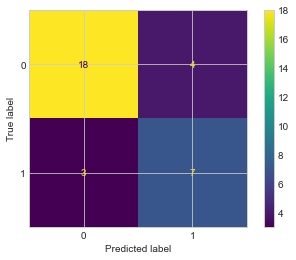

In [62]:
# Logistic Regression
def log_reg(X_test, X_train, y_train, y_test, level):
    classifier = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear', random_state = 0)
    classifier.fit(X_train, y_train)
    
    # MAKE PREDICTION
    y_pred = classifier.predict(X_test)
    score1 = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression at level {level}")
    print("=====================================")
    print(f"The accuracy score is: {score1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    
    # Cross validation
    scores = cross_val_score(classifier, X_train, y_train, cv=10)
    print(f"The cv scores at level {level} are {scores}")
    print(f"The mean accuracy of cv: {np.mean(cross_val_score(classifier, X_train, y_train, cv=10))}")
    
    #y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    
for (X_test, X_train, y_train, y_test, level) in data_list:
    log_reg(X_test, X_train, y_train, y_test, level)

## Random Forest

Logistic Regression at level 1
The accuracy score is: 0.375
The confusion matrix at level 1 is: 
 [[2 2]
 [3 1]]
The cv scores at level 1 are [0.5        0.75       0.66666667 0.33333333 0.66666667 1.
 0.66666667 0.         0.66666667 0.66666667]
The mean accuracy of cv: 0.5583333333333333


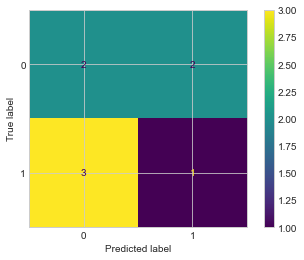

Logistic Regression at level 2
The accuracy score is: 0.625
The confusion matrix at level 2 is: 
 [[2 1]
 [2 3]]
The cv scores at level 2 are [0.5        0.5        1.         0.66666667 0.         1.
 0.66666667 1.         0.66666667 0.66666667]
The mean accuracy of cv: 0.6333333333333333


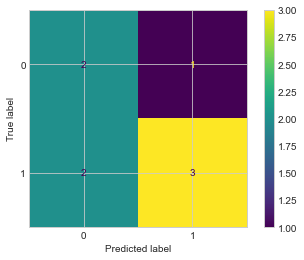

Logistic Regression at level 3
The accuracy score is: 0.5
The confusion matrix at level 3 is: 
 [[1 1]
 [3 3]]
The cv scores at level 3 are [0.5        0.25       1.         0.33333333 0.66666667 0.66666667
 1.         0.         0.33333333 0.33333333]
The mean accuracy of cv: 0.5083333333333332


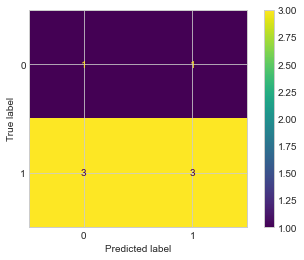

Logistic Regression at level 4
The accuracy score is: 0.75
The confusion matrix at level 4 is: 
 [[3 2]
 [0 3]]
The cv scores at level 4 are [0.5        0.75       0.33333333 0.66666667 0.         0.66666667
 0.33333333 0.66666667 0.33333333 0.33333333]
The mean accuracy of cv: 0.4916666666666666


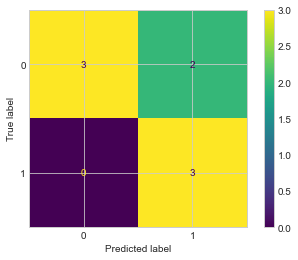

Logistic Regression at level ALL
The accuracy score is: 0.8125
The confusion matrix at level ALL is: 
 [[18  4]
 [ 2  8]]
The cv scores at level ALL are [0.84615385 1.         0.84615385 0.92307692 0.76923077 0.76923077
 0.92307692 0.92307692 1.         0.83333333]
The mean accuracy of cv: 0.8916666666666666


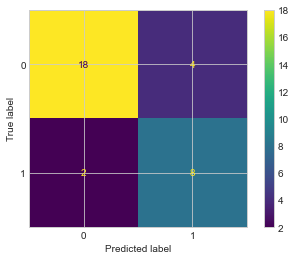

/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_cla

/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_cla

/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_cla

/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/albinekstrom/Documents/GitHub/BikeFit/venv/lib/python3.7/site-packages/sklearn/neighbors/_cla

In [71]:
# Random Forest
def forest(X_test, X_train, y_train, y_test, level):
    forest_classifier = RandomForestClassifier(max_features = 'log2', n_estimators = 1000, criterion = 'entropy')
    forest_classifier.fit(X_train, y_train)
    
    # MAKE PREDICTION
    y_pred = forest_classifier.predict(X_test)
    score1 = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression at level {level}")
    print("=====================================")
    print(f"The accuracy score is: {score1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    
    # Cross validation
    scores = cross_val_score(forest_classifier, X_train, y_train, cv=10)
    print(f"The cv scores at level {level} are {scores}")
    print(f"The mean accuracy of cv: {np.mean(cross_val_score(forest_classifier, X_train, y_train, cv=10))}")
    
    #y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()


for (X_test, X_train, y_train, y_test, level) in data_list:
    forest_classifier = forest(X_test, X_train, y_train, y_test, level)

## Naive Bayes

Logistic Regression at level 1
The accuracy score is: 0.5
The confusion matrix at level 1 is: 
 [[4 0]
 [4 0]]
The cv scores at level 1 are [0.25       0.25       0.66666667 0.66666667 1.         0.66666667
 0.66666667 0.33333333 0.33333333 0.66666667]
The mean accuracy of cv: 0.55


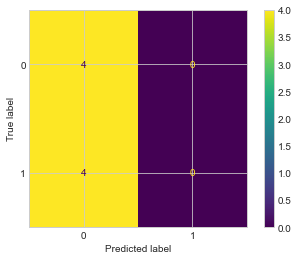

Logistic Regression at level 2
The accuracy score is: 0.625
The confusion matrix at level 2 is: 
 [[1 2]
 [1 4]]
The cv scores at level 2 are [0.75       0.75       1.         0.66666667 0.33333333 0.66666667
 0.66666667 0.33333333 0.33333333 0.33333333]
The mean accuracy of cv: 0.5833333333333333


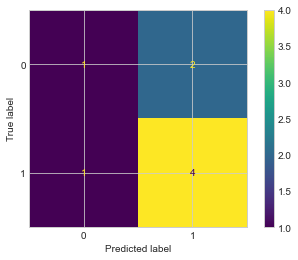

Logistic Regression at level 3
The accuracy score is: 0.75
The confusion matrix at level 3 is: 
 [[1 1]
 [1 5]]
The cv scores at level 3 are [0.75       0.25       0.66666667 0.33333333 0.33333333 1.
 0.33333333 0.33333333 0.66666667 0.33333333]
The mean accuracy of cv: 0.5


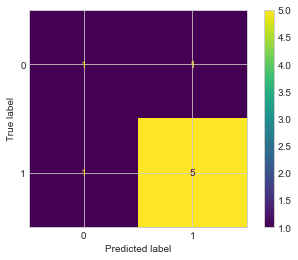

Logistic Regression at level 4
The accuracy score is: 0.75
The confusion matrix at level 4 is: 
 [[4 1]
 [1 2]]
The cv scores at level 4 are [0.75       0.5        0.66666667 0.33333333 0.         0.33333333
 0.         0.33333333 0.33333333 0.        ]
The mean accuracy of cv: 0.325


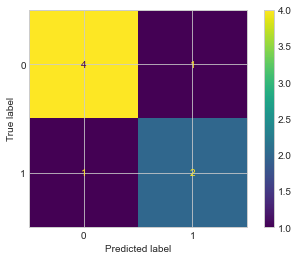

Logistic Regression at level ALL
The accuracy score is: 0.3125
The confusion matrix at level ALL is: 
 [[ 4 18]
 [ 4  6]]
The cv scores at level ALL are [0.53846154 0.76923077 0.61538462 0.61538462 0.61538462 0.61538462
 0.69230769 0.69230769 0.83333333 0.5       ]
The mean accuracy of cv: 0.6487179487179486


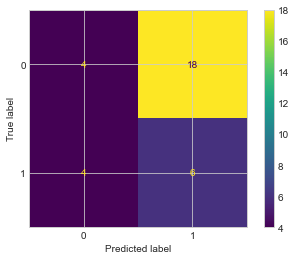

In [55]:
#Naive Bayes
def naive(X_test, X_train, y_train, y_test, level):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train, y_train)
    
    # MAKE PREDICTION
    y_pred = naive_classifier.predict(X_test)
    score1 = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression at level {level}")
    print("=====================================")
    print(f"The accuracy score is: {score1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    
    # Cross validation
    scores = cross_val_score(naive_classifier, X_train, y_train, cv=10)
    print(f"The cv scores at level {level} are {scores}")
    print(f"The mean accuracy of cv: {np.mean(cross_val_score(naive_classifier, X_train, y_train, cv=10))}")
    
    #y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
for (X_test, X_train, y_train, y_test, level) in data_list:
    naive(X_test, X_train, y_train, y_test, level)

## K-nearest neighbour (KNC) 

KNC at level 1
The accuracy score is: 0.375
The confusion matrix at level 1 is: 
 [[1 3]
 [2 2]]
The cv scores at level 1 are [0.5        1.         0.33333333 0.66666667 0.66666667 0.66666667
 0.66666667 0.33333333 0.33333333 0.33333333]
The mean accuracy of cv: 0.5499999999999999


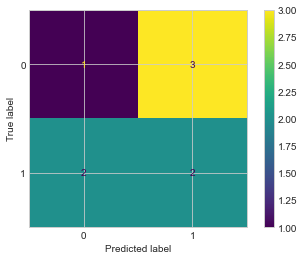

KNC at level 2
The accuracy score is: 0.5
The confusion matrix at level 2 is: 
 [[2 1]
 [3 2]]
The cv scores at level 2 are [0.5        0.         0.66666667 0.33333333 0.33333333 0.66666667
 0.33333333 0.         0.66666667 0.        ]
The mean accuracy of cv: 0.35


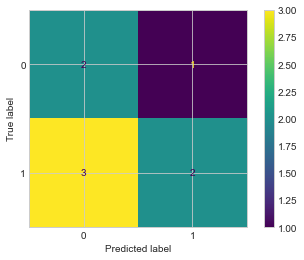

KNC at level 3
The accuracy score is: 0.5
The confusion matrix at level 3 is: 
 [[1 1]
 [3 3]]
The cv scores at level 3 are [0.5        0.5        0.33333333 0.         0.33333333 0.66666667
 0.66666667 0.         0.33333333 0.66666667]
The mean accuracy of cv: 0.4


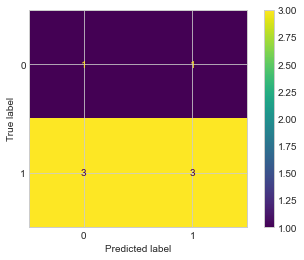

KNC at level 4
The accuracy score is: 0.5
The confusion matrix at level 4 is: 
 [[1 4]
 [0 3]]
The cv scores at level 4 are [0.         0.5        0.66666667 0.         0.         0.33333333
 0.66666667 0.33333333 0.33333333 0.        ]
The mean accuracy of cv: 0.2833333333333333


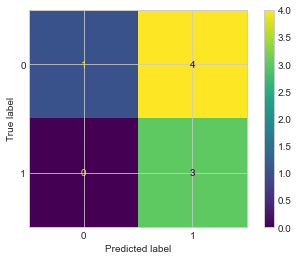

KNC at level ALL
The accuracy score is: 0.84375
The confusion matrix at level ALL is: 
 [[18  4]
 [ 1  9]]
The cv scores at level ALL are [0.92307692 0.76923077 0.92307692 0.92307692 0.92307692 0.92307692
 0.92307692 0.92307692 1.         0.91666667]
The mean accuracy of cv: 0.9147435897435898


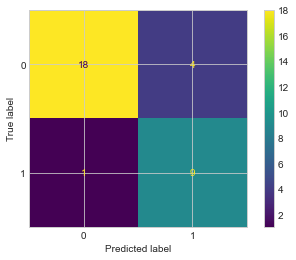

In [67]:
#KNC
def knc(X_test, X_train, y_train, y_test, level):
    KNC_classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'manhattan', weights = 'uniform', p = 2)
    KNC_classifier.fit(X_train, y_train)
    
    # MAKE PREDICTION
    y_pred = KNC_classifier.predict(X_test)
    score1 = accuracy_score(y_test, y_pred)
    print(f"KNC at level {level}")
    print("=====================================")
    print(f"The accuracy score is: {score1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    
    # Cross validation
    scores = cross_val_score(KNC_classifier, X_train, y_train, cv=10)
    print(f"The cv scores at level {level} are {scores}")
    print(f"The mean accuracy of cv: {np.mean(cross_val_score(KNC_classifier, X_train, y_train, cv=10))}")
    
    #y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
for (X_test, X_train, y_train, y_test, level) in data_list:
    knc(X_test, X_train, y_train, y_test, level)

## Linear support vector classification (SVC)

SVC at level 1
The accuracy score is: 0.375
The confusion matrix at level 1 is: 
 [[1 3]
 [2 2]]
The cv scores at level 1 are [0.5        0.75       0.66666667 0.33333333 1.         1.
 0.33333333 0.         0.66666667 0.66666667]
The mean accuracy of cv: 0.5916666666666668


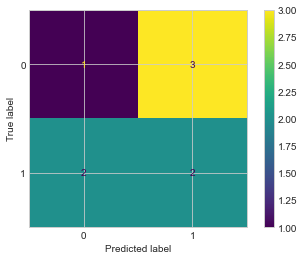

SVC at level 2
The accuracy score is: 0.5
The confusion matrix at level 2 is: 
 [[1 2]
 [2 3]]
The cv scores at level 2 are [0.75       0.75       1.         0.66666667 1.         1.
 1.         0.66666667 0.66666667 0.        ]
The mean accuracy of cv: 0.75


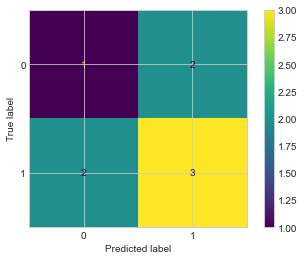

SVC at level 3
The accuracy score is: 0.625
The confusion matrix at level 3 is: 
 [[1 1]
 [2 4]]
The cv scores at level 3 are [0.75       0.5        0.33333333 0.33333333 1.         0.66666667
 0.66666667 0.33333333 0.33333333 0.33333333]
The mean accuracy of cv: 0.5249999999999999


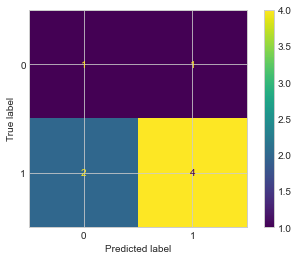

SVC at level 4
The accuracy score is: 0.75
The confusion matrix at level 4 is: 
 [[4 1]
 [1 2]]
The cv scores at level 4 are [0.25       0.75       0.33333333 0.33333333 0.33333333 1.
 0.33333333 0.         0.33333333 0.        ]
The mean accuracy of cv: 0.36666666666666664


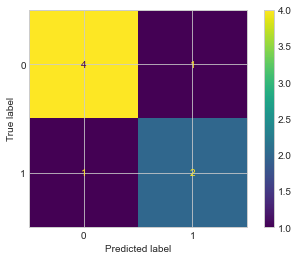

SVC at level ALL
The accuracy score is: 0.78125
The confusion matrix at level ALL is: 
 [[18  4]
 [ 3  7]]
The cv scores at level ALL are [0.76923077 0.84615385 1.         0.61538462 0.84615385 0.84615385
 0.76923077 0.76923077 0.83333333 0.91666667]
The mean accuracy of cv: 0.8211538461538461


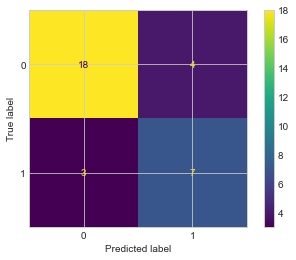

In [57]:
#SVC
def svc(X_test, X_train, y_train, y_test, level):
    SVC_classifier = SVC(kernel = 'linear', random_state = 0)
    SVC_classifier.fit(X_train, y_train)
    
    # MAKE PREDICTION
    y_pred = SVC_classifier.predict(X_test)
    score1 = accuracy_score(y_test, y_pred)
    print(f"SVC at level {level}")
    print("=====================================")
    print(f"The accuracy score is: {score1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    
    # Cross validation
    scores = cross_val_score(SVC_classifier, X_train, y_train, cv=10)
    print(f"The cv scores at level {level} are {scores}")
    print(f"The mean accuracy of cv: {np.mean(cross_val_score(SVC_classifier, X_train, y_train, cv=10))}")
    
    #y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
for (X_test, X_train, y_train, y_test, level) in data_list:
    svc(X_test, X_train, y_train, y_test, level)

## XGBoost

SVC at level 1
The accuracy score is: 0.375
The confusion matrix at level 1 is: 
 [[2 2]
 [3 1]]
The cv scores at level 1 are [0.75       0.5        1.         0.33333333 0.66666667 0.66666667
 0.66666667 0.33333333 1.         0.66666667]
The mean accuracy of cv: 0.6583333333333333


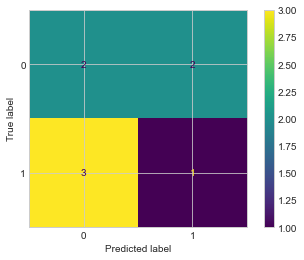

SVC at level 2
The accuracy score is: 0.5
The confusion matrix at level 2 is: 
 [[1 2]
 [2 3]]
The cv scores at level 2 are [0.75       0.5        1.         0.66666667 0.33333333 0.33333333
 0.66666667 1.         0.66666667 0.33333333]
The mean accuracy of cv: 0.625


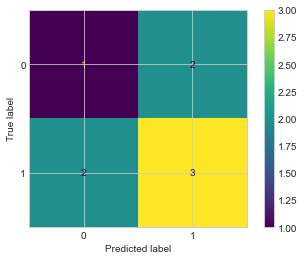

SVC at level 3
The accuracy score is: 0.75
The confusion matrix at level 3 is: 
 [[1 1]
 [1 5]]
The cv scores at level 3 are [0.25       0.25       1.         0.         0.33333333 0.66666667
 0.66666667 0.         0.33333333 0.33333333]
The mean accuracy of cv: 0.38333333333333336


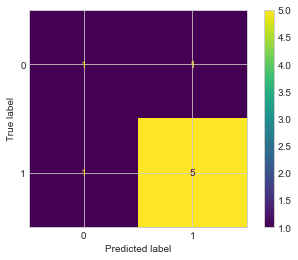

SVC at level 4
The accuracy score is: 0.75
The confusion matrix at level 4 is: 
 [[4 1]
 [1 2]]
The cv scores at level 4 are [0.75       0.75       0.66666667 0.66666667 0.         0.66666667
 0.         0.66666667 0.33333333 0.33333333]
The mean accuracy of cv: 0.4833333333333332


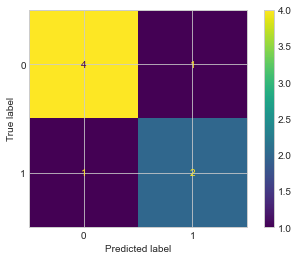

SVC at level ALL
The accuracy score is: 0.71875
The confusion matrix at level ALL is: 
 [[15  7]
 [ 2  8]]
The cv scores at level ALL are [0.76923077 0.84615385 0.84615385 0.84615385 0.61538462 0.61538462
 0.92307692 1.         1.         0.83333333]
The mean accuracy of cv: 0.8294871794871795


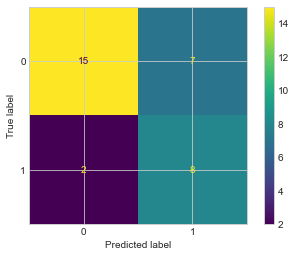

In [60]:
#XGB

def xgb(X_test, X_train, y_train, y_test, level):
    XGB_classifier = XGBClassifier(use_label_encoder = False,
                              learning_rate=0.1,
                              max_depth=10,
                              scale_pos_weight=1.5,
                              eval_metric='mlogloss')
    XGB_classifier.fit(X_train, y_train)
    
    # MAKE PREDICTION
    y_pred = XGB_classifier.predict(X_test)
    score1 = accuracy_score(y_test, y_pred)
    print(f"SVC at level {level}")
    print("=====================================")
    print(f"The accuracy score is: {score1}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"The confusion matrix at level {level} is: \n {cm}")
    
    # Cross validation
    scores = cross_val_score(XGB_classifier, X_train, y_train, cv=10)
    print(f"The cv scores at level {level} are {scores}")
    print(f"The mean accuracy of cv: {np.mean(cross_val_score(XGB_classifier, X_train, y_train, cv=10))}")
    
    #y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()


for (X_test, X_train, y_train, y_test, level) in data_list:
    xgb(X_test, X_train, y_train, y_test, level)

In [70]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

grid_result = grid_search.fit(X_train, y_train.values.ravel())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.867094 using {'max_features': 'log2', 'n_estimators': 1000}
0.789316 (0.106826) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.854274 (0.097455) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.851068 (0.106645) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.766026 (0.119097) with: {'max_features': 'log2', 'n_estimators': 10}
0.851068 (0.096958) with: {'max_features': 'log2', 'n_estimators': 100}
0.867094 (0.094486) with: {'max_features': 'log2', 'n_estimators': 1000}
